<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [1]:
from __future__ import division, print_function
from time import time
import itertools
import os
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 100)
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('../Dataset/capstone_user_identification')

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
    
with open(os.path.join(PATH_TO_DATA, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, test_size=0.3, 
                                                      random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [7]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [8]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
%%time
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
scores_knn_train = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
print(scores_knn_train)

[ 0.56377473  0.56145166  0.55979256]
CPU times: user 1.98 s, sys: 724 ms, total: 2.71 s
Wall time: 4.25 s


In [54]:
%%time
knn_clf = knn.fit(X_train, y_train)
y_pred = knn_clf.predict(X_valid)
knn_clf_score = accuracy_score(y_valid, y_pred)
print(knn_clf_score)

0.584024650391
CPU times: user 1.15 s, sys: 440 ms, total: 1.59 s
Wall time: 2.53 s


**Запишите в файл *answer4_1.txt* доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [60]:
answer = np.round([np.mean(scores_knn_train), knn_clf_score], 3)
answer = ' '.join(map(str, answer))
print(answer)

write_answer_to_file(answer, 'answer4_1.txt')

0.562 0.584


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
%%time
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)
scores_forest_train = cross_val_score(forest, X_train, y_train, cv=skf, scoring='accuracy')
print(scores_forest_train)

[ 0.71354642  0.71851174  0.71262965]
CPU times: user 45.2 s, sys: 124 ms, total: 45.3 s
Wall time: 13.6 s


In [64]:
%%time
forest_clf = forest.fit(X_train, y_train)
y_pred = forest_clf.predict(X_valid)
forest_clf_score = accuracy_score(y_valid, y_pred)
print(forest_clf_score)

0.735008295805
CPU times: user 23.6 s, sys: 76 ms, total: 23.6 s
Wall time: 6.87 s


**Запишите в файл *answer4_2.txt* доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [65]:
answer = np.round([np.mean(scores_forest_train), forest_clf_score], 3)
answer = ' '.join(map(str, answer))
print(answer)

write_answer_to_file(answer, 'answer4_2.txt')

0.715 0.735


In [67]:
!cat answer4_2.txt

0.715 0.735

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [68]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [69]:
%%time
logit = LogisticRegression(random_state=17, n_jobs=-1)
scores_logit_train = cross_val_score(logit, X_train, y_train, cv=skf, scoring='accuracy')
print(scores_logit_train)

[ 0.76225266  0.76059774  0.76479561]
CPU times: user 2.66 s, sys: 12 ms, total: 2.67 s
Wall time: 1.35 s


In [70]:
%%time
logit_clf = logit.fit(X_train, y_train)
y_pred = logit_clf.predict(X_valid)
logit_clf_score = accuracy_score(y_valid, y_pred)
print(logit_clf_score)

0.781701825077
CPU times: user 1.46 s, sys: 8 ms, total: 1.47 s
Wall time: 744 ms


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [83]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1.tolist(), multi_class='multinomial',
                                            cv=skf, random_state=17, n_jobs=-1)
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 2.93 s, sys: 124 ms, total: 3.05 s
Wall time: 20.7 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [111]:
logit_mean_cv_scores1 = logit_grid_searcher1.scores_[1][0]
logit_c_values1 = logit_grid_searcher1.Cs_

logit_mean_cv_scores1

array([ 0.32724505,  0.46940639,  0.55190259,  0.64231355,  0.71171994,
        0.74581431,  0.75920852,  0.76164384,  0.75494673,  0.74611872])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [112]:
print(np.max(logit_mean_cv_scores1))
print(logit_grid_searcher1.C_[0])

0.761643835616
4.64158883361


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

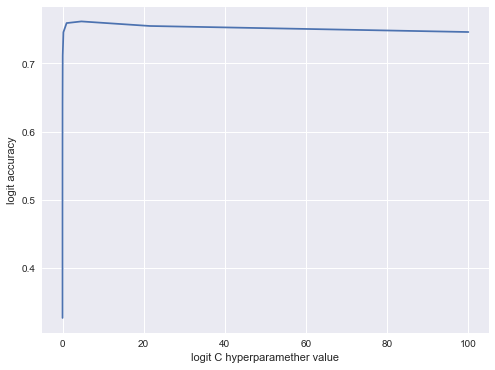

In [119]:
plt.figure(figsize=(8,6))
plt.plot(logit_c_values1, logit_mean_cv_scores1);
plt.xlabel('logit C hyperparamether value')
plt.ylabel('logit accuracy');

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(3, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [124]:
%%time
logit_c_values2 = np.linspace(3, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2.tolist(), multi_class='multinomial',
                                            cv=skf, random_state=17, n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 2.98 s, sys: 144 ms, total: 3.12 s
Wall time: 58.3 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [125]:
logit_mean_cv_scores2 = logit_grid_searcher2.scores_[1][0]
logit_c_values2 = logit_grid_searcher2.Cs_

logit_mean_cv_scores2

array([ 0.76438356,  0.76407915,  0.76407915,  0.76438356,  0.76499239,
        0.76377473,  0.76468798,  0.76407915,  0.76407915,  0.76347032,
        0.76286149,  0.76164384,  0.76103501,  0.76073059,  0.75981735,
        0.75920852,  0.75981735,  0.75981735,  0.76042618,  0.75981735])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [226]:
i = np.argmax(logit_mean_cv_scores2)
print(logit_grid_searcher2.scores_[1][0][i])
print(logit_grid_searcher2.Cs_[i])

0.76499238965
3.84210526316


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [220]:
logit_grid_searcher2.C_

array([ 3.42105263,  3.42105263,  3.42105263,  3.42105263,  3.42105263,
        3.42105263,  3.42105263,  3.42105263,  3.42105263,  3.42105263])

In [217]:
logit_c_values2

array([ 3.        ,  3.21052632,  3.42105263,  3.63157895,  3.84210526,
        4.05263158,  4.26315789,  4.47368421,  4.68421053,  4.89473684,
        5.10526316,  5.31578947,  5.52631579,  5.73684211,  5.94736842,
        6.15789474,  6.36842105,  6.57894737,  6.78947368,  7.        ])

In [218]:
logit_mean_cv_scores2

array([ 0.76438356,  0.76407915,  0.76407915,  0.76438356,  0.76499239,
        0.76377473,  0.76468798,  0.76407915,  0.76407915,  0.76347032,
        0.76286149,  0.76164384,  0.76103501,  0.76073059,  0.75981735,
        0.75920852,  0.75981735,  0.75981735,  0.76042618,  0.75981735])

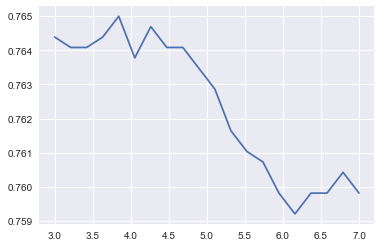

In [127]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [128]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
logit_cv_acc

0.77956861815596112

**Запишите в файл *answer4_3.txt* доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [130]:
answer = np.round([np.max(logit_mean_cv_scores2), logit_cv_acc], 3)
answer = ' '.join(map(str, answer))
print(answer)

write_answer_to_file(answer, 'answer4_3.txt')

0.765 0.78


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [131]:
from sklearn.svm import LinearSVC

In [133]:
svm = LinearSVC(C=1, random_state=17)

In [146]:
%%time
scores_svm_train = cross_val_score(svm, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print(scores_svm_train)

[ 0.75677321  0.75327844  0.75930445]
CPU times: user 80 ms, sys: 108 ms, total: 188 ms
Wall time: 2.69 s


In [147]:
%%time
svm_clf = svm.fit(X_train, y_train)
y_pred = svm_clf.predict(X_valid)
svm_clf_score = accuracy_score(y_valid, y_pred)
print(svm_clf_score)

0.776961365252
CPU times: user 2.26 s, sys: 4 ms, total: 2.26 s
Wall time: 2.26 s


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [134]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, scoring='accuracy', n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.64 s, sys: 128 ms, total: 3.77 s
Wall time: 36.8 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [136]:
print(svm_grid_searcher1.best_score_)
print(svm_grid_searcher1.best_params_)

0.684820158504
{'C': 7777.7778000000008}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

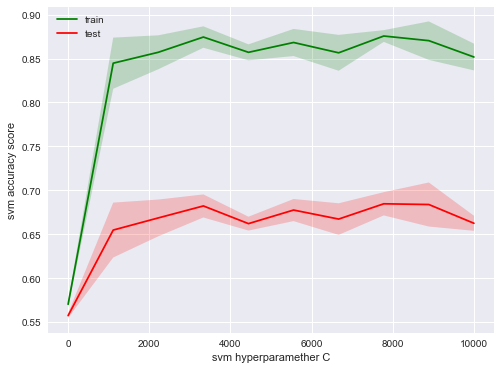

In [140]:
plt.figure(figsize=(8, 6))
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)
plt.xlabel('svm hyperparamether C')
plt.ylabel('svm accuracy score');

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [154]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv=skf, scoring='accuracy', n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.92 s, sys: 144 ms, total: 2.06 s
Wall time: 57.4 s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [155]:
print(svm_grid_searcher2.best_score_)
print(svm_grid_searcher2.best_params_)

0.764986791303
{'C': 0.24213793103448275}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

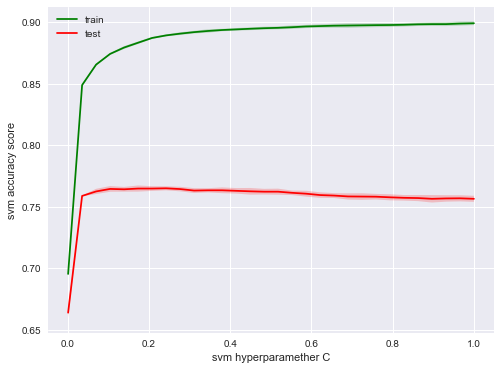

In [156]:
plt.figure(figsize=(8, 6))
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)
plt.xlabel('svm hyperparamether C')
plt.ylabel('svm accuracy score');

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [157]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
svm_cv_acc

0.78359800900687371

**Запишите в файл *answer4_4.txt* доли правильных ответов для svm_grid_searcher2 на кросс-валидации для лучшего значения параметра С и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [158]:
answer = np.round([svm_grid_searcher2.best_score_, svm_cv_acc], 3)
answer = ' '.join(map(str, answer))
print(answer)

write_answer_to_file(answer, 'answer4_4.txt')

0.765 0.784


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [174]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    # Loading prepaired dataset
    with open(path_to_X_pickle, 'rb') as f:
        X = pickle.load(f)
        
    with open(path_to_y_pickle, 'rb') as f:
        y = pickle.load(f)
        
    # Split dataset on train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Cross validation scores
    estimator_cv_scores = cross_val_score(estimator, X_train, y_train, cv=skf, n_jobs=-1)
    
    # Test score
    estimator.fit(X_train, y_train)
    estimator_test_score = accuracy_score(y_test, estimator.predict(X_test))
    
    return [np.mean(estimator_cv_scores), estimator_test_score]

**Убедитесь, что функция работает.**

In [175]:
model_assessment(svm_grid_searcher2.best_estimator_, os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
                 os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

[0.76661217569606821, 0.77814648020858024]

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

In [201]:
%%time
estimator = svm_grid_searcher2.best_estimator_

res_list = []

num_users = 10
print('window_size', 'session_length', 'mean_cv_score', 'test_score')
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        fname_X_cur = 'X_sparse_' + str(num_users) + 'users_s' + str(session_length)+'_w' + \
                      str(window_size) + '.pkl'
        fname_y_cur = 'y_' + str(num_users) + 'users_s' + str(session_length)+'_w' + \
                      str(window_size) + '.pkl'
        path_to_X_pkl = os.path.join(PATH_TO_DATA, fname_X_cur)
        path_to_y_pkl = os.path.join(PATH_TO_DATA, fname_y_cur)
        
        model_res = model_assessment(svm_grid_searcher2.best_estimator_, path_to_X_pkl, path_to_y_pkl,
                                     skf, random_state=17, test_size=0.3)

        res_list.append([window_size, session_length, model_res[0], model_res[1]])
        
        print('{:11} {:14} {:13} {:10}'.format(window_size, session_length,
                                               round(model_res[0], 3), round(model_res[1], 3)))
        
columns=['window_size', 'session_length', 'mean_cv_score', 'test_score']
win_size_sess_len_search_res = pd.DataFrame(res_list, columns=columns)

window_size session_length mean_cv_score test_score
         10             15          0.82       0.84
         10             10         0.767      0.778
          7             15         0.843      0.871
          7             10         0.799      0.813
          7              7         0.749      0.763
          5             15         0.869      0.878
          5             10         0.823      0.827
          5              7         0.775       0.78
          5              5         0.729      0.734
CPU times: user 19.2 s, sys: 408 ms, total: 19.6 s
Wall time: 46.9 s


In [202]:
win_size_sess_len_search_res

,window_size,session_length,mean_cv_score,test_score
0,10,15,0.820262,0.840009
1,10,10,0.766612,0.778146
2,7,15,0.843244,0.870914
3,7,10,0.798578,0.812510
4,7,7,0.749360,0.762900
5,5,15,0.869120,0.878378
6,5,10,0.822527,0.826577
7,5,7,0.774972,0.780346
8,5,5,0.729397,0.733523


**Запишите в файл *answer4_5.txt* доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [212]:
answer = np.round(win_size_sess_len_search_res.iloc[5, 2:].values, 3)
answer = ' '.join(map(str, answer))
print(answer)
             
write_answer_to_file(answer, 'answer4_5.txt')

0.869 0.878


**Прокомментируйте полученные результаты. WOW! Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [213]:
%%time
estimator = svm_grid_searcher2.best_estimator_

res_list = []

num_users = 150
print('window_size', 'session_length', 'mean_cv_score', 'test_score')
for window_size, session_length in [(5,5), (7,7), (10,10)]:
    fname_X_cur = 'X_sparse_' + str(num_users) + 'users_s' + str(session_length)+'_w' + \
                  str(window_size) + '.pkl'
    fname_y_cur = 'y_' + str(num_users) + 'users_s' + str(session_length)+'_w' + \
                  str(window_size) + '.pkl'
    path_to_X_pkl = os.path.join(PATH_TO_DATA, fname_X_cur)
    path_to_y_pkl = os.path.join(PATH_TO_DATA, fname_y_cur)

    model_res = model_assessment(svm_grid_searcher2.best_estimator_, path_to_X_pkl, path_to_y_pkl,
                                 skf, random_state=17, test_size=0.3)

    res_list.append([window_size, session_length, model_res[0], model_res[1]])

    print('{:11} {:14} {:13} {:10}'.format(window_size, session_length,
                                           round(model_res[0], 3), round(model_res[1], 3)))
        
columns=['window_size', 'session_length', 'mean_cv_score', 'test_score']
win_size_sess_len_search_res = pd.DataFrame(res_list, columns=columns)

window_size session_length mean_cv_score test_score
          5              5         0.411      0.422
          7              7         0.439      0.453
         10             10         0.462      0.483
CPU times: user 14min 6s, sys: 556 ms, total: 14min 6s
Wall time: 28min 45s


**Запишите в файл *answer4_6.txt* доли правильных ответов для LinearSVC с настроенным параметром C и выборки *X_sparse_150users*. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и запишите в файл через пробел.**

In [214]:
answer = np.round(win_size_sess_len_search_res.iloc[2, 2:].values, 3)
answer = ' '.join(map(str, answer))
print(answer)
             
write_answer_to_file(answer, 'answer4_6.txt')

0.462 0.483


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [215]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users_s10_w10.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users_s10_w10.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [216]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [229]:
%%time
i = np.argmax(logit_mean_cv_scores2)

logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[i]], multi_class='ovr',
                                         n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 7min 36s, sys: 2.13 s, total: 7min 38s
Wall time: 10min 23s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [276]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = np.mean(logit_cv_150users.scores_[user_id])
    print('User {}, CV score: {}'.format(user_id, cv_scores_by_user[user_id]))

User 1, CV score: 0.995891871538
User 2, CV score: 0.996277931615
User 3, CV score: 0.995224888976
User 4, CV score: 0.991847149375
User 5, CV score: 0.990272314936
User 6, CV score: 0.994359611631
User 7, CV score: 0.99362974295
User 8, CV score: 0.985893267507
User 9, CV score: 0.997946057818
User 10, CV score: 0.995266567028
User 11, CV score: 0.994193134313
User 12, CV score: 0.993650663358
User 13, CV score: 0.996768042994
User 14, CV score: 0.994755600157
User 15, CV score: 0.99633003694
User 16, CV score: 0.996246705035
User 17, CV score: 0.990574877499
User 18, CV score: 0.994588945554
User 19, CV score: 0.991471138274
User 20, CV score: 0.980660171008
User 21, CV score: 0.996893043271
User 22, CV score: 0.994745460069
User 23, CV score: 0.990950148049
User 24, CV score: 0.996746971022
User 25, CV score: 0.994234558588
User 26, CV score: 0.994964191904
User 27, CV score: 0.99179493747
User 28, CV score: 0.984538720976
User 29, CV score: 0.996976098145
User 30, CV score: 0.99710

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [281]:
class_unq, class_cnts = np.unique(y_train_150, return_counts=True)
class_prop = []

for i, user_id in enumerate(class_unq):
    class_prop.append(1 - class_cnts[i] / np.sum(class_cnts))
    
cv_scores = []
for id_num, prop in zip(class_unq, class_prop):
    score = cv_scores_by_user[id_num]
    cv_scores.append(score)
    print(id_num, prop, score)

1 0.984402531461 0.995891871538
2 0.995704440483 0.996277931615
3 0.994401176066 0.995224888976
4 0.984715314921 0.991847149375
5 0.987947410674 0.990272314936
6 0.994453306642 0.994359611631
7 0.992545327536 0.99362974295
8 0.98391250404 0.985893267507
9 0.997122392168 0.997946057818
10 0.993827739722 0.995266567028
11 0.994150949298 0.994193134313
12 0.992044874 0.993650663358
13 0.996924295977 0.996768042994
14 0.99485992514 0.994755600157
15 0.996350859633 0.99633003694
16 0.996194467903 0.996246705035
17 0.990074338202 0.990574877499
18 0.994745237872 0.994588945554
19 0.990439252239 0.991471138274
20 0.976999989574 0.980660171008
21 0.996017223943 0.996893043271
22 0.987217582601 0.994745460069
23 0.990001355395 0.990950148049
24 0.995944241135 0.996746971022
25 0.993660921877 0.994234558588
26 0.99405711426 0.994964191904
27 0.98750951383 0.99179493747
28 0.979596092292 0.984538720976
29 0.997111966053 0.996976098145
30 0.996778330362 0.997101513443
31 0.996538529709 0.996892940

In [287]:
diff_score_prop = np.array(cv_scores) - np.array(class_prop)
num_better_than_default = (diff_score_prop > 0).sum()
num_better_than_default

118

In [274]:
num_better_than_default = 121

**Запишите в файл *answer4_7.txt* долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой. **

In [275]:
write_answer_to_file(round(num_better_than_default/150, 3), 'answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
В этом проекте свобода творчества на каждом шаге, а 7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взимному оцениванию. Что еще можно добавить по 4 части проекта:
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей

На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.